## Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import scipy.stats

default_figsize = (12.8, 4.8)

## Data

### Household Demographic

In [2]:
# Household demographics
df_household = pd.read_csv('dunnhumby/hh_demographic.csv', sep = ',')

#### Data Cleaning

In [3]:
# correct dtypes
df_household['MARITAL_STATUS_CODE'] = df_household['MARITAL_STATUS_CODE'].astype('category')
df_household['HOMEOWNER_DESC'] =  df_household['HOMEOWNER_DESC'].astype('category')
df_household['HH_COMP_DESC'] = df_household['HH_COMP_DESC'].astype('category')
df_household['HOUSEHOLD_SIZE_DESC'] = pd.Categorical(df_household['HOUSEHOLD_SIZE_DESC'].values, categories=['1', '2', '3', '4', '5+'], ordered=True)
df_household['KID_CATEGORY_DESC'] = pd.Categorical(df_household['KID_CATEGORY_DESC'].values, categories=['None/Unknown', '1', '2', '3+'], ordered=True)

# merge some income categories
cat_to_combine_under50K = ["Under 15K", "15-24K", "25-34K", "35-49K"]
cat_to_combine_between50K_100K = ["50-74K", "75-99K"]
cat_to_combine_over100K = ["100-124K", "125-149K", "150-174K", "175-199K", "200-249K", "250K+"]
def combine_cat_income(x):
    if x in cat_to_combine_over100K:
        return "100K+"
    elif x in cat_to_combine_between50K_100K:
        return "50-99K"
    elif x in cat_to_combine_under50K:
        return "Under 50K"
    else:
        print(x)
        return 'ERROR'
    
df_household['INCOME_DESC'] = df_household['INCOME_DESC'].apply(combine_cat_income)

# merge some age categories
cat_to_combine_over55 = ["55-64", "65+"]
cat_to_combine_under35 = ["19-24", "25-34"]
def combine_cat_age(x):
    if x in cat_to_combine_over55:
        return "55+" 
    elif x in cat_to_combine_under35:
        return "19-34"
    else: 
        return x
    
df_household['AGE_DESC'] = df_household['AGE_DESC'].apply(combine_cat_age)

# correct dtypes
df_household['INCOME_DESC'] = pd.Categorical(df_household['INCOME_DESC'].values, categories=['Under 50K', '50-99K', '100K+'], ordered=True)
df_household['AGE_DESC'] = pd.Categorical(df_household['AGE_DESC'].values, categories=['19-34', '35-44', '45-54', '55+'], ordered=True)

### Products

In [4]:
df_products = pd.read_csv('dunnhumby/product.csv', sep = ',')
df_food_products = pd.read_csv('data/food_products.csv')

df_meat_products = pd.read_csv('data/meat_products.csv')
df_veggies_products = pd.read_csv('data/vegetables_products.csv')

df_pure_meat = pd.read_csv("data/pure_meat_products.csv")
df_red_meat = df_pure_meat[df_pure_meat.MEAT_TYPE.isin(['BOVINE', 'OVINE','PORK'])]
df_white_meat = df_pure_meat[df_pure_meat.MEAT_TYPE.isin(['POULTRY'])]
df_sea_food = df_pure_meat[df_pure_meat.MEAT_TYPE.isin(['SEAFOOD'])]

### Transactions

In [5]:
df_transactions = pd.read_csv("data/clean_transactions.csv")
df_food_transactions = pd.read_csv("data/food_transactions.csv")

df_meat_transactions = pd.merge(df_meat_products, df_food_transactions, on="PRODUCT_ID", how="inner")
df_veggies_transactions = pd.merge(df_veggies_products, df_food_transactions, on="PRODUCT_ID", how="inner")

df_pure_meat_transactions = pd.merge(df_pure_meat, df_food_transactions, on="PRODUCT_ID", how="inner")
df_red_meat_transactions = pd.merge(df_red_meat, df_food_transactions, on="PRODUCT_ID", how="inner")
df_white_meat_transactions = pd.merge(df_white_meat, df_food_transactions, on="PRODUCT_ID", how="inner")
df_sea_food_transactions = pd.merge(df_sea_food, df_food_transactions, on="PRODUCT_ID", how="inner")

### Aggregated Dataset

In [6]:
# find active weeks  and total spendings per household
weeks_activity_by_household = df_food_transactions.groupby("household_key").agg({"WEEK_NO": set, "PAID_PRICE": sum})
# create new columns
weeks_activity_by_household["number_of_active_weeks"] = weeks_activity_by_household["WEEK_NO"].apply(lambda x: len(x))
weeks_activity_by_household["avg_spending_per_week"] = weeks_activity_by_household["PAID_PRICE"] / weeks_activity_by_household["number_of_active_weeks"]
# drop week_no and sort
weeks_activity_by_household = weeks_activity_by_household.drop(columns="WEEK_NO")
weeks_activity_by_household = weeks_activity_by_household.sort_values(by="number_of_active_weeks", ascending=False).rename(columns={"PAID_PRICE": "PAID_FOOD"})

In [7]:
# find active weeks  and total spendings per household
weeks_activity_by_household = df_food_transactions.groupby("household_key").agg({"WEEK_NO": set, "PAID_PRICE": sum})
# create new columns
weeks_activity_by_household["number_of_active_weeks"] = weeks_activity_by_household["WEEK_NO"].apply(lambda x: len(x))
weeks_activity_by_household["avg_spending_per_week"] = weeks_activity_by_household["PAID_PRICE"] / weeks_activity_by_household["number_of_active_weeks"]
# drop week_no and sort
weeks_activity_by_household = weeks_activity_by_household.drop(columns="WEEK_NO")
weeks_activity_by_household = weeks_activity_by_household.sort_values(by="number_of_active_weeks", ascending=False).rename(columns={"PAID_PRICE": "PAID_FOOD"})

# add more info 
dfs = [df_meat_transactions, df_veggies_transactions, df_pure_meat_transactions, df_red_meat_transactions, df_white_meat_transactions, df_sea_food_transactions]
df_names = ['MEAT', 'VEGGIE', 'PURE_MEAT', 'RED_MEAT', 'WHITE_MEAT', 'SEA_FOOD']

spent_by_household = weeks_activity_by_household.rename(columns={"PAID_PRICE_x": "paid_FOOD", "PAID_PRICE_y": "paid"})
for name, df in zip(df_names, dfs):
    spending = df.groupby("household_key").agg({"PAID_PRICE": sum}).reset_index().rename(columns={"PAID_PRICE": "PAID_" + name})
    spent_by_household = pd.merge(spending, spent_by_household, on="household_key")
    
    spent_by_household['avg_spending_per_week_' + name] = spent_by_household['PAID_' + name] / spent_by_household['number_of_active_weeks']
    spent_by_household['avg_spending_ratio_' + name] = spent_by_household['avg_spending_per_week_' + name] / spent_by_household['avg_spending_per_week']
    
spent_by_household.head()

,household_key,PAID_SEA_FOOD,PAID_WHITE_MEAT,PAID_RED_MEAT,PAID_PURE_MEAT,PAID_VEGGIE,PAID_MEAT,PAID_FOOD,number_of_active_weeks,avg_spending_per_week,...,avg_spending_per_week_VEGGIE,avg_spending_ratio_VEGGIE,avg_spending_per_week_PURE_MEAT,avg_spending_ratio_PURE_MEAT,avg_spending_per_week_RED_MEAT,avg_spending_ratio_RED_MEAT,avg_spending_per_week_WHITE_MEAT,avg_spending_ratio_WHITE_MEAT,avg_spending_per_week_SEA_FOOD,avg_spending_ratio_SEA_FOOD
0,1,8.64,161.68,57.68,261.16,292.81,380.95,2812.21,67,41.973284,...,4.370299,0.104121,3.897910,0.092866,0.860896,0.020511,2.413134,0.057492,0.128955,0.003072
1,2,38.20,52.44,85.50,200.66,58.14,225.75,1082.74,31,34.927097,...,1.875484,0.053697,6.472903,0.185326,2.758065,0.078966,1.691613,0.048433,1.232258,0.035281
2,3,9.47,63.97,208.94,393.85,41.01,567.90,1711.78,36,47.549444,...,1.139167,0.023958,10.940278,0.230082,5.803889,0.122060,1.776944,0.037370,0.263056,0.005532
3,4,12.47,41.88,72.98,156.83,9.70,177.87,679.48,25,27.179200,...,0.388000,0.014276,6.273200,0.230809,2.919200,0.107406,1.675200,0.061635,0.498800,0.018352
4,6,123.69,384.85,592.27,1104.95,371.72,1141.56,3794.65,84,45.174405,...,4.425238,0.097959,13.154167,0.291186,7.050833,0.156080,4.581548,0.101419,1.472500,0.032596


## Distribution of Demographics

### Distributions of Categories

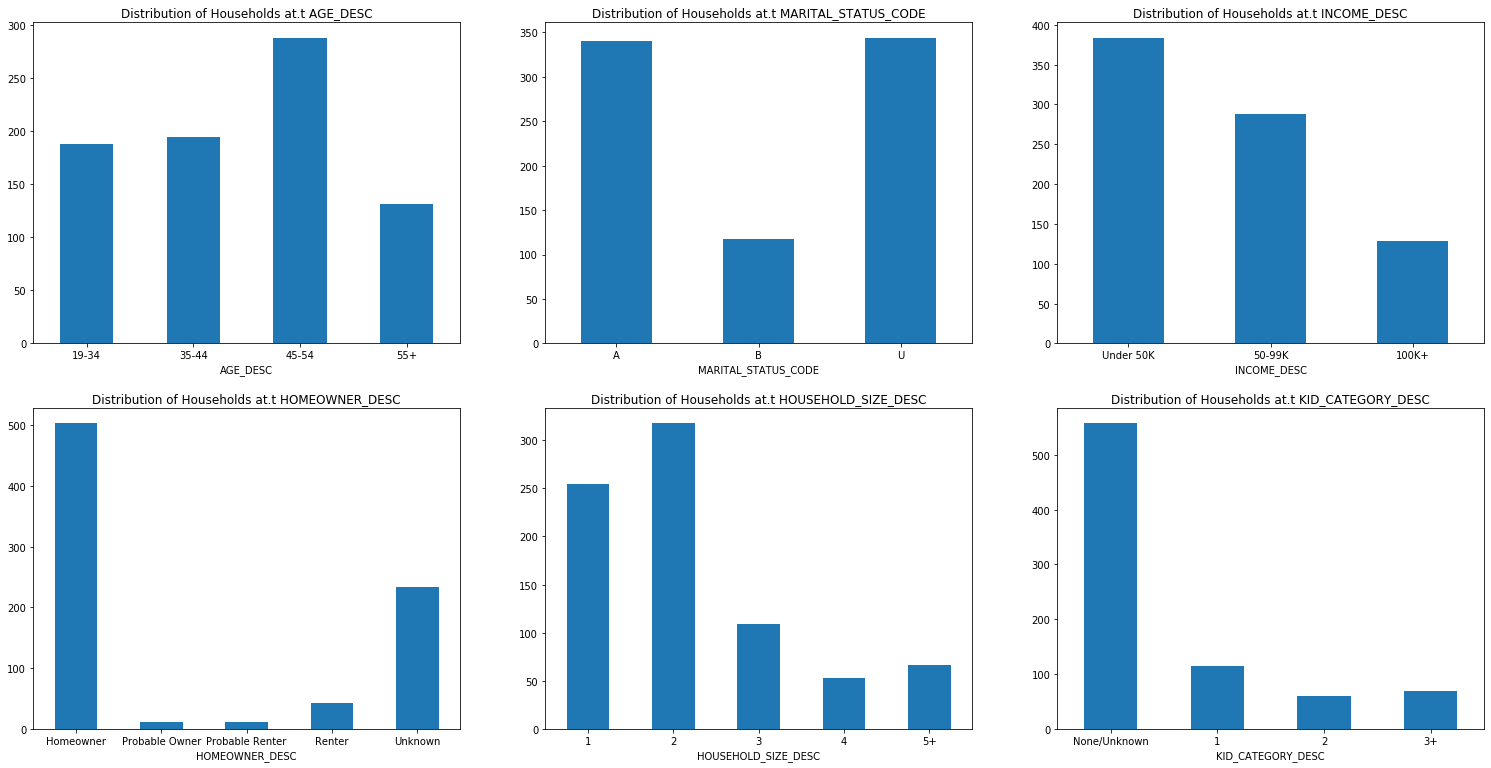

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,13))

for i, n in enumerate(['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC']):
    df_household.groupby(n)['household_key'].count().plot.bar(ax=axes[i // 3,i % 3], title='Distribution of Households at.t ' + n)
    axes[i // 3,i % 3].set_xticklabels(axes[i // 3,i % 3].get_xticklabels(), rotation=0)

### Joint Distributions of Each Two Categories

In [38]:
df_household.columns

Index(['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC',
       'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC',
       'household_key'],
      dtype='object')

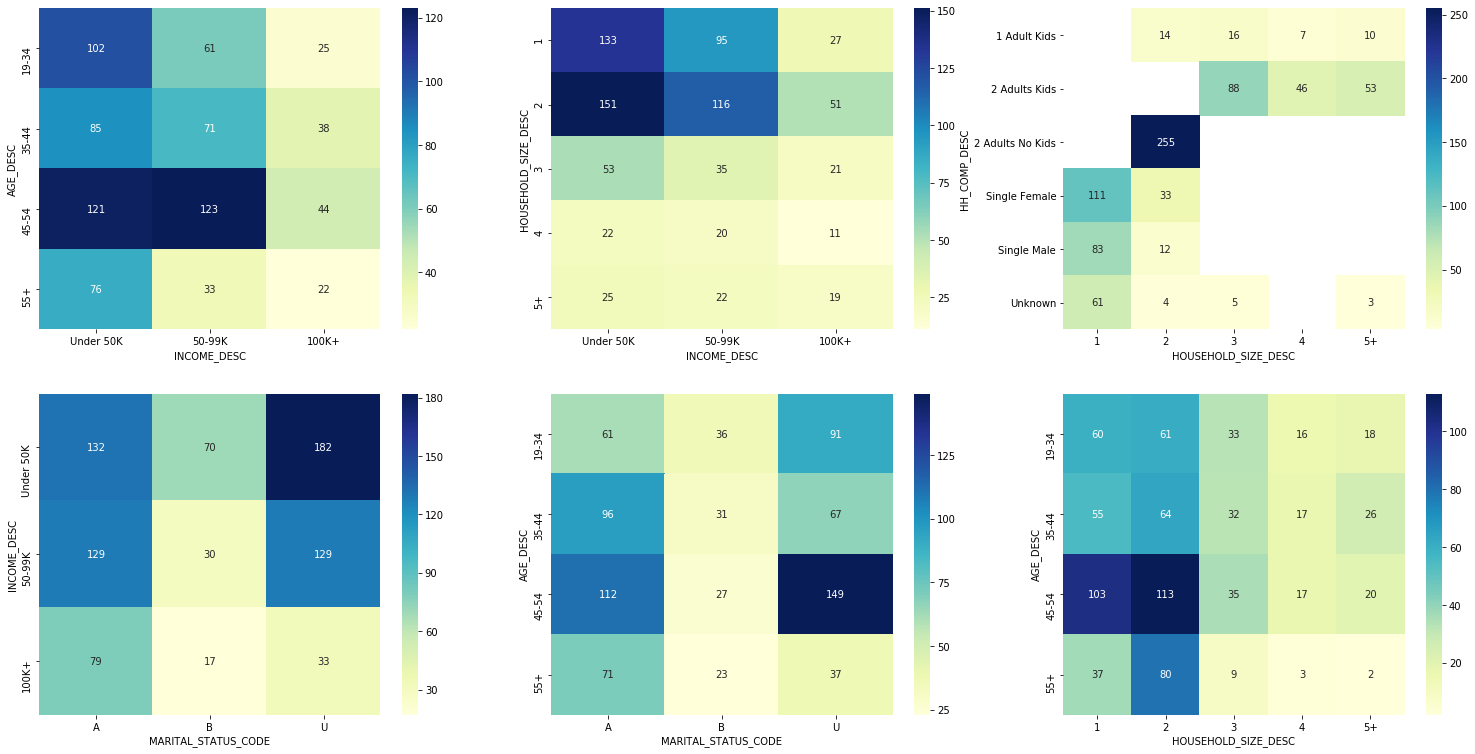

In [55]:
tuples = [
    ('AGE_DESC', 'INCOME_DESC'),
    ('HOUSEHOLD_SIZE_DESC', 'INCOME_DESC'),
    ('HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC'),

    ('INCOME_DESC', 'MARITAL_STATUS_CODE'),
    ('AGE_DESC', 'MARITAL_STATUS_CODE'),
    ('AGE_DESC', 'HOUSEHOLD_SIZE_DESC')]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,13))

for i, t in enumerate(tuples):
    df_dummy = df_household.groupby([t[0], t[1]]).count()\
        .reset_index().pivot(index= t[0], columns= t[1], values='household_key')
    
    sns.heatmap(df_dummy, annot=True, fmt=".0f", annot_kws={"size": 10}, cmap="YlGnBu", ax=axes[i // 3,i % 3])
    
    b, t = axes[i // 3,i % 3].set_ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    axes[i // 3,i % 3].set_ylim(b, t) # update the ylim(bottom, top) values

## Analysis

In [10]:
df_spent_and_demog=pd.merge(df_household, spent_by_household, on='household_key', how='inner')

In [11]:
def plot_bars(df, demographic_feature, order=None):
    COLS_OF_INTEREST = [
    "avg_spending_per_week",
    "avg_spending_per_week_MEAT",   
    "avg_spending_per_week_VEGGIE",  
    "avg_spending_per_week_PURE_MEAT",
    "avg_spending_per_week_RED_MEAT",
    "avg_spending_per_week_WHITE_MEAT",
    "avg_spending_per_week_SEA_FOOD",
        
    "number_of_active_weeks",
    "avg_spending_ratio_MEAT",
    "avg_spending_ratio_VEGGIE",
    "avg_spending_ratio_PURE_MEAT",
    "avg_spending_ratio_RED_MEAT", 
    "avg_spending_ratio_WHITE_MEAT",
    "avg_spending_ratio_SEA_FOOD",
    ]
    
    rows, cols = 2, 7
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(36,12))
    
    for i, col in enumerate(COLS_OF_INTEREST):    
        chart = sns.barplot(x = demographic_feature, y =col, data = df, ax = axes[i // cols, i % cols], order=order)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

        axes[i // cols, i % cols].set_title(col)
        b, t = axes[i // cols, i % cols].set_ylim() # discover the values for bottom and top
        b -= (t - b)/50 # Add 0.5 to the bottom
        t += (t - b)/10 # Subtract 0.5 from the top
        axes[i // cols, i % cols].set_ylim(b, t) # update the ylim(bottom, top) values
        
    fig.tight_layout()

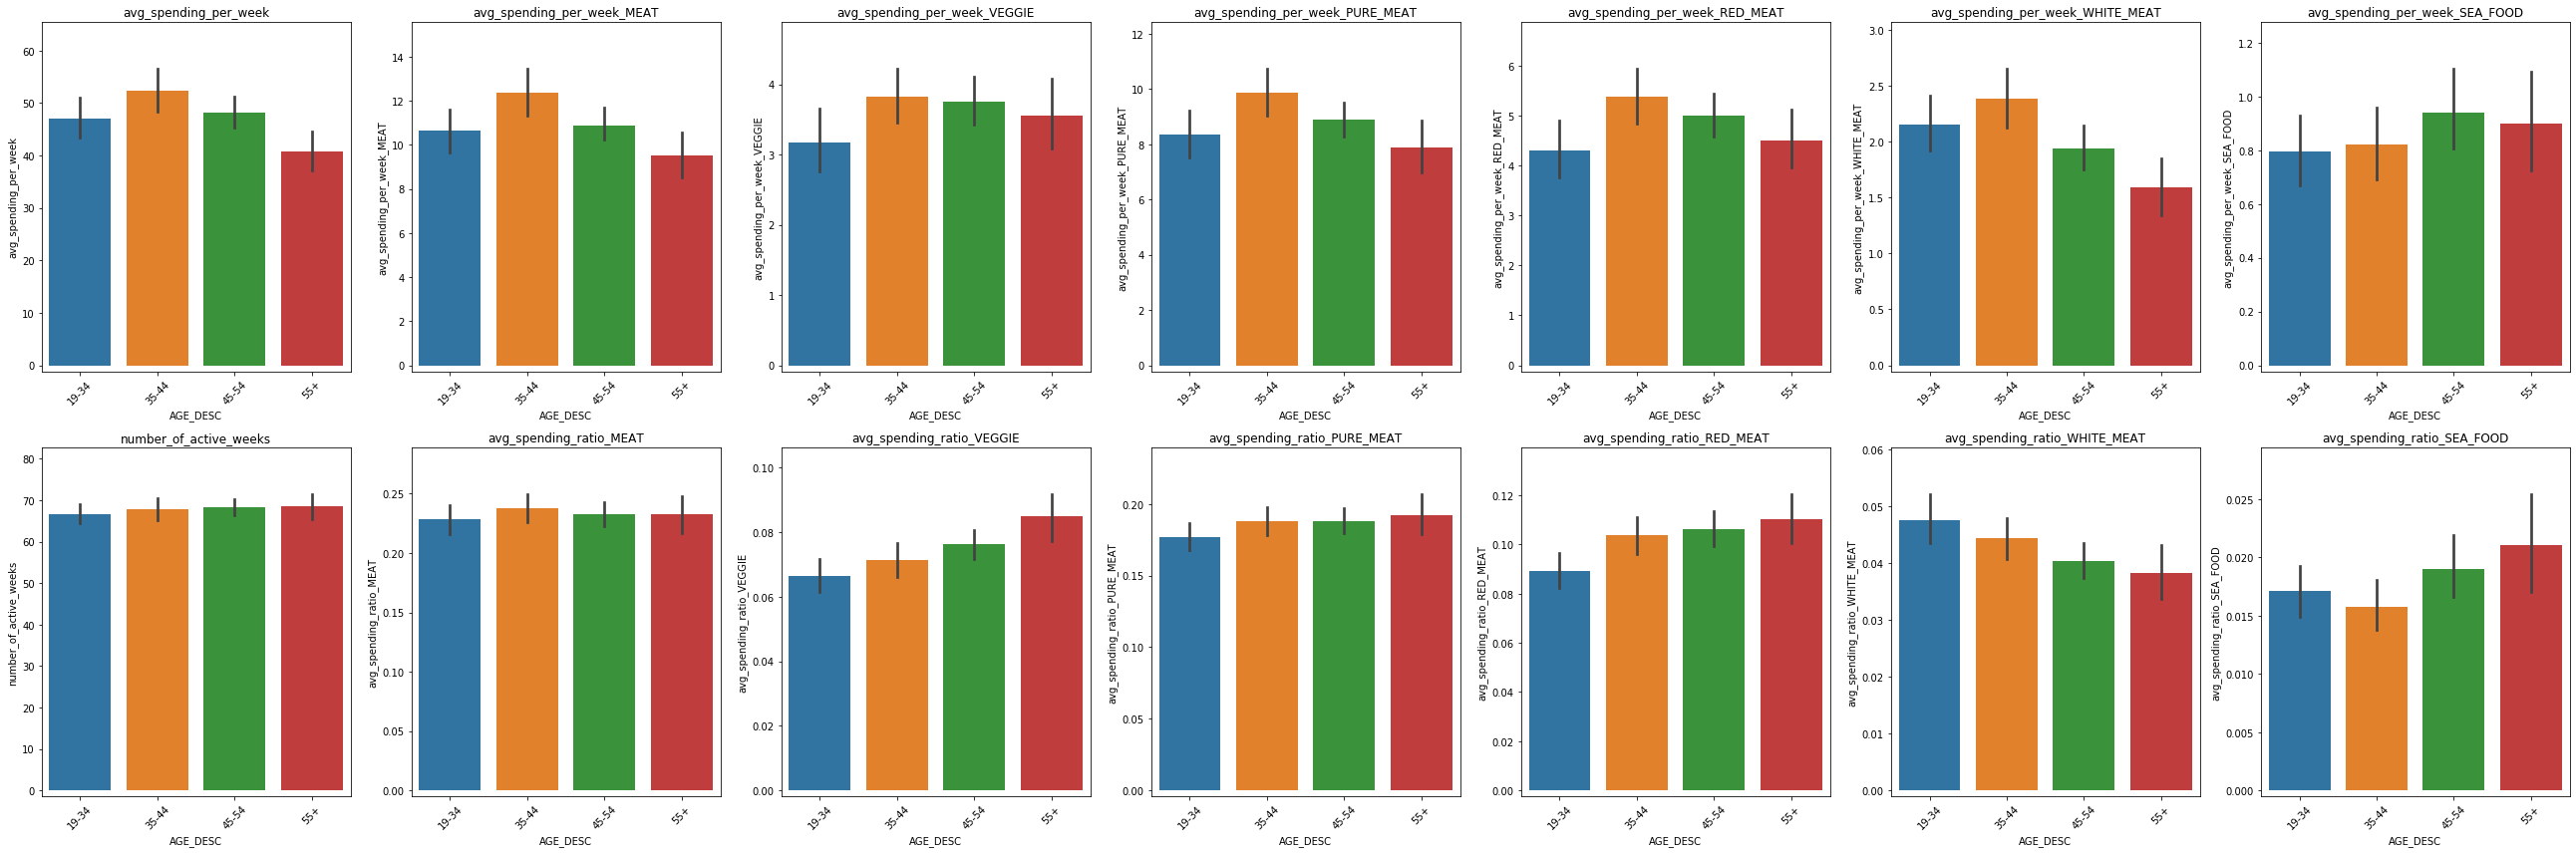

In [12]:
plot_bars(df_spent_and_demog, 'AGE_DESC')

In [49]:
def plot_heatmap(df_spent_and_demog, KEY, THRESHOLD, COLS_OF_INTEREST, METHOD='mean', ):
    def ci(data, confidence=0.9):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return 2*h
    
    def threshold_groups(df, threshold, KEY):
        valid_indices = df.groupby([KEY[0], KEY[1]]).count()['household_key'] >= threshold
        for k0, k1 in valid_indices.index:
            if not valid_indices[k0][k1]:
                df = df[(df[KEY[0]] != k0) | (df[KEY[1]] != k1)]
        return df

    rows, cols = 1, len(COLS_OF_INTEREST)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(50,5))

    for i, col in enumerate(COLS_OF_INTEREST):
        
        df_dummy = threshold_groups(df_spent_and_demog, THRESHOLD, KEY)
        if METHOD == 'mean':
            df_dummy = df_dummy.groupby([KEY[0], KEY[1]]).agg({col: 'mean'})\
                                     .reset_index().pivot(index= KEY[0], columns= KEY[1], values=col)
            color = "YlGnBu"

        elif METHOD == 'ci':
            df_dummy = df_dummy.groupby([KEY[0], KEY[1]]).agg({col: ci})\
                                     .reset_index().pivot(index= KEY[0], columns= KEY[1], values=col)
            color = None#'Reds'

        if 'ratio' in col or 'SEA' in col:
            sns.heatmap(df_dummy, annot=True, fmt=".04f", annot_kws={"size": 10}, cmap=color, ax=axes[i])
        elif 'WHITE' in col:
            sns.heatmap(df_dummy, annot=True, fmt=".02f", annot_kws={"size": 10}, cmap=color, ax=axes[i])
        else:
            sns.heatmap(df_dummy, annot=True, fmt=".00f", annot_kws={"size": 10}, cmap=color, ax=axes[i])
            
        axes[i].set_title(col + ' ' + METHOD)
        b, t = axes[i].set_ylim() # discover the values for bottom and top
        b += 0.5 # Add 0.5 to the bottom
        t -= 0.5 # Subtract 0.5 from the top
        axes[i].set_ylim(b, t) # update the ylim(bottom, top) values
    
def plot_heatmaps(variables, threshold):
    avg_spending_mean = [
    "avg_spending_per_week",
    "avg_spending_per_week_MEAT",   
    "avg_spending_per_week_VEGGIE",  
    "avg_spending_per_week_PURE_MEAT",
    "avg_spending_per_week_RED_MEAT",
    "avg_spending_per_week_WHITE_MEAT",
    "avg_spending_per_week_SEA_FOOD",
    ]

    avg_spending_ratio = [
    "number_of_active_weeks",
    "avg_spending_ratio_MEAT",
    "avg_spending_ratio_VEGGIE",
    "avg_spending_ratio_PURE_MEAT",
    "avg_spending_ratio_RED_MEAT", 
    "avg_spending_ratio_WHITE_MEAT",
    "avg_spending_ratio_SEA_FOOD",
    ]
    
    KEY, THRESHOLD = variables, threshold
    plot_heatmap(df_spent_and_demog, KEY=KEY, THRESHOLD=THRESHOLD, COLS_OF_INTEREST=avg_spending_mean, METHOD='mean')
    plot_heatmap(df_spent_and_demog, KEY=KEY, THRESHOLD=0, COLS_OF_INTEREST=avg_spending_mean, METHOD='ci')
    plot_heatmap(df_spent_and_demog, KEY=KEY, THRESHOLD=THRESHOLD, COLS_OF_INTEREST=avg_spending_ratio, METHOD='mean')
    plot_heatmap(df_spent_and_demog, KEY=KEY, THRESHOLD=0, COLS_OF_INTEREST=avg_spending_ratio, METHOD='ci')

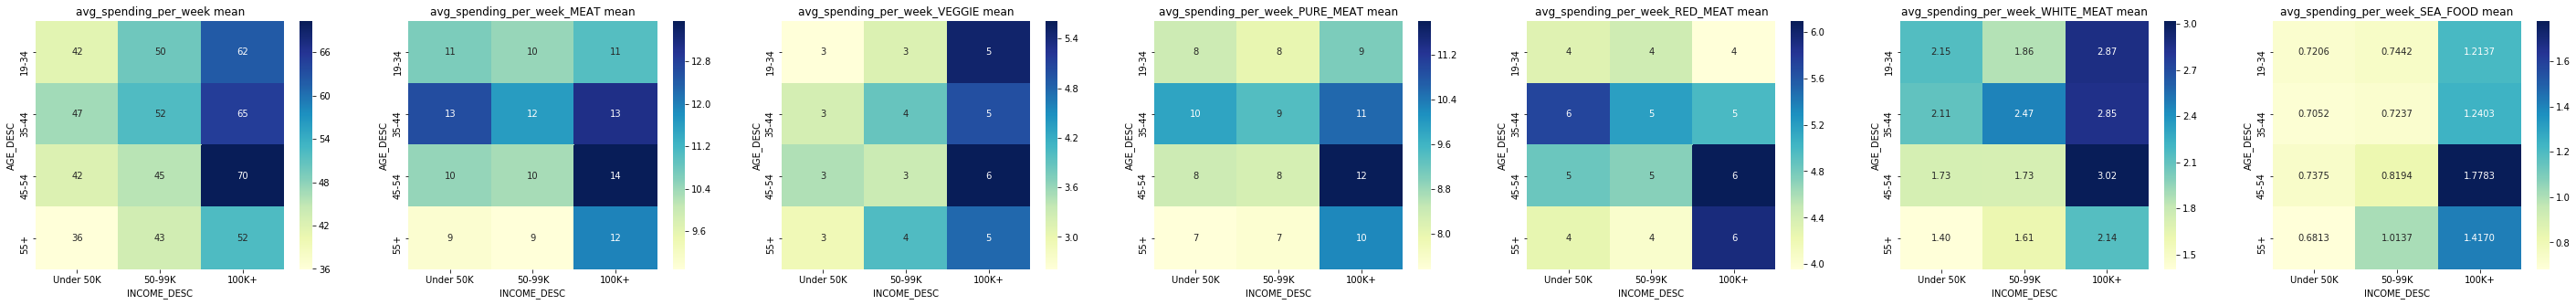

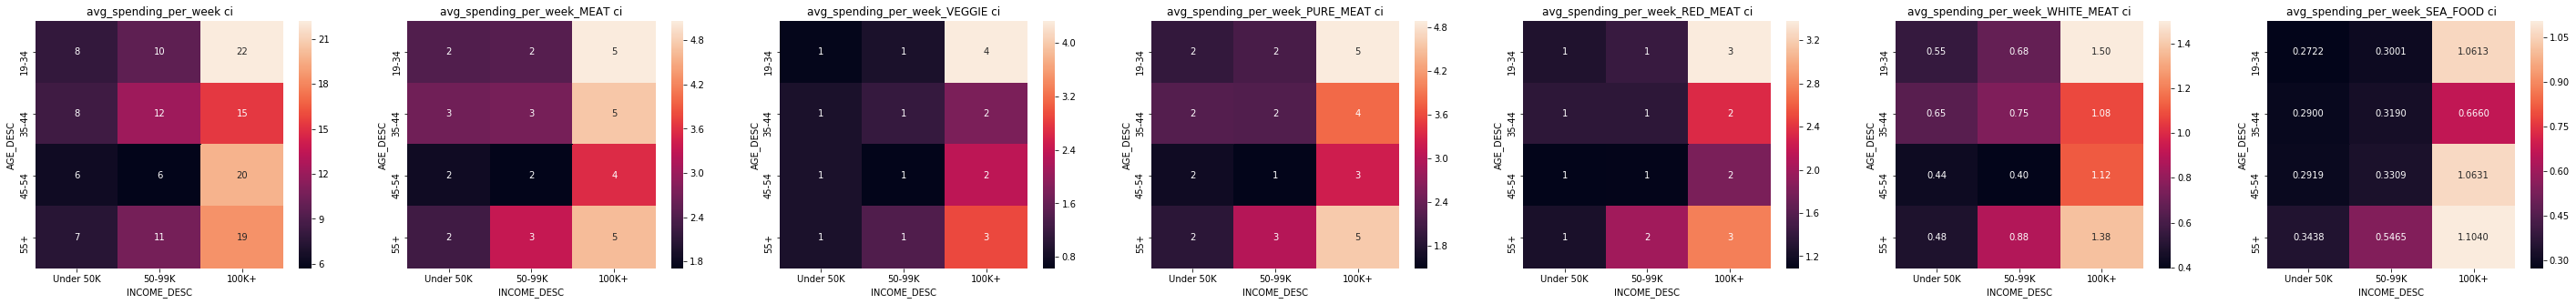

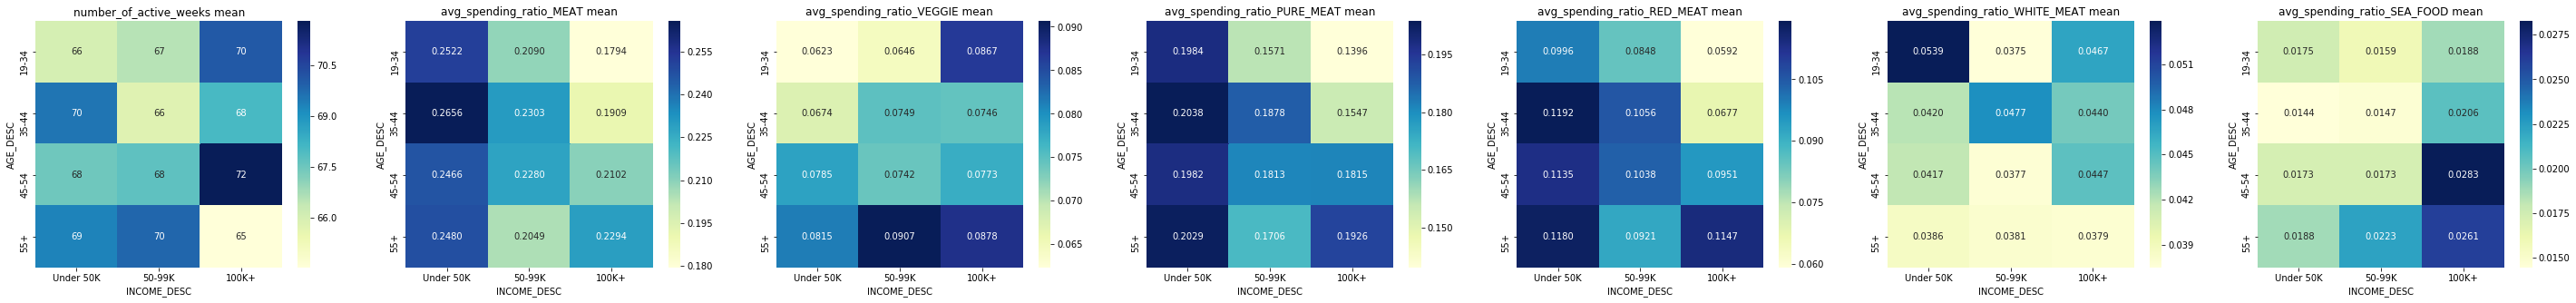

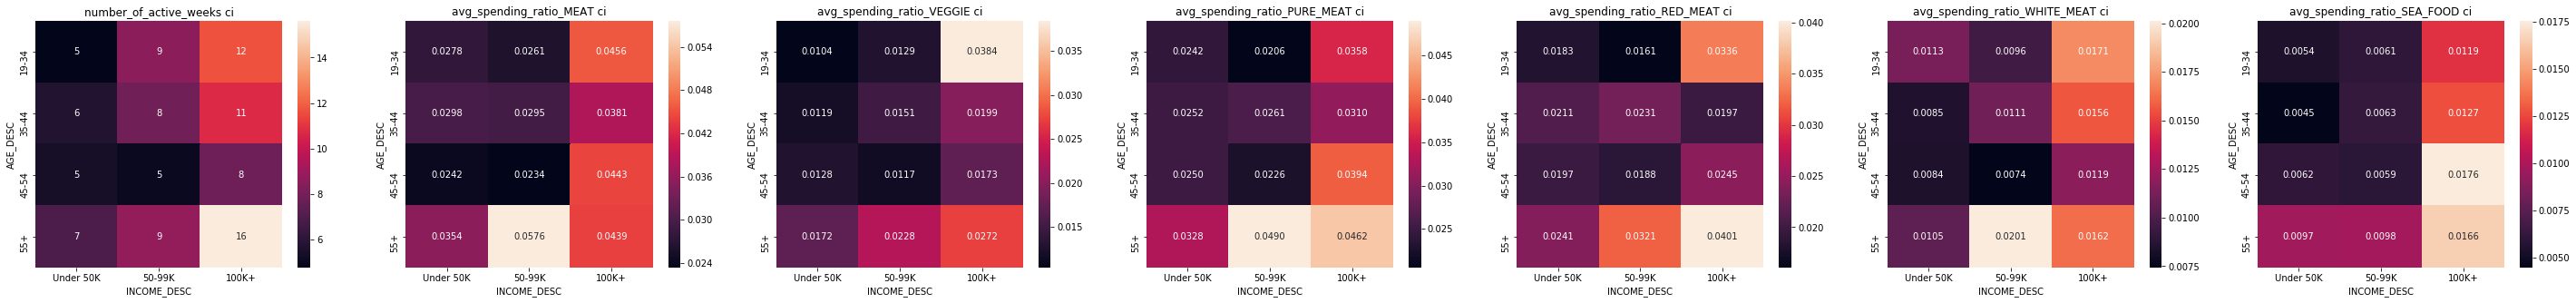

In [51]:
plot_heatmaps(('AGE_DESC', 'INCOME_DESC'), 0)

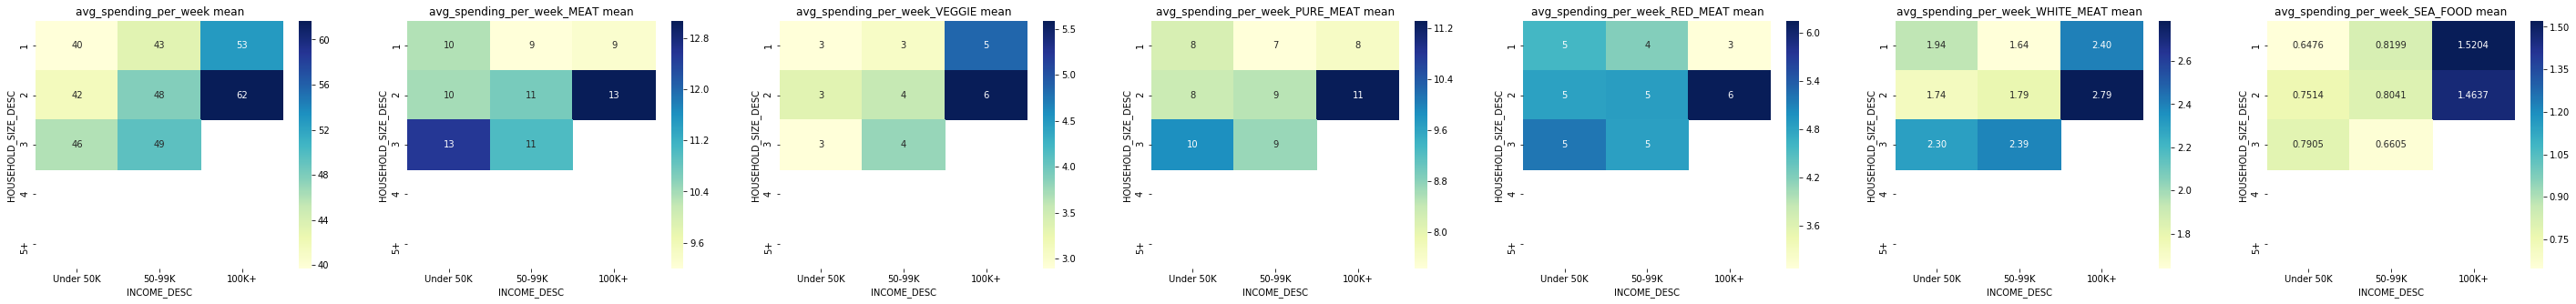

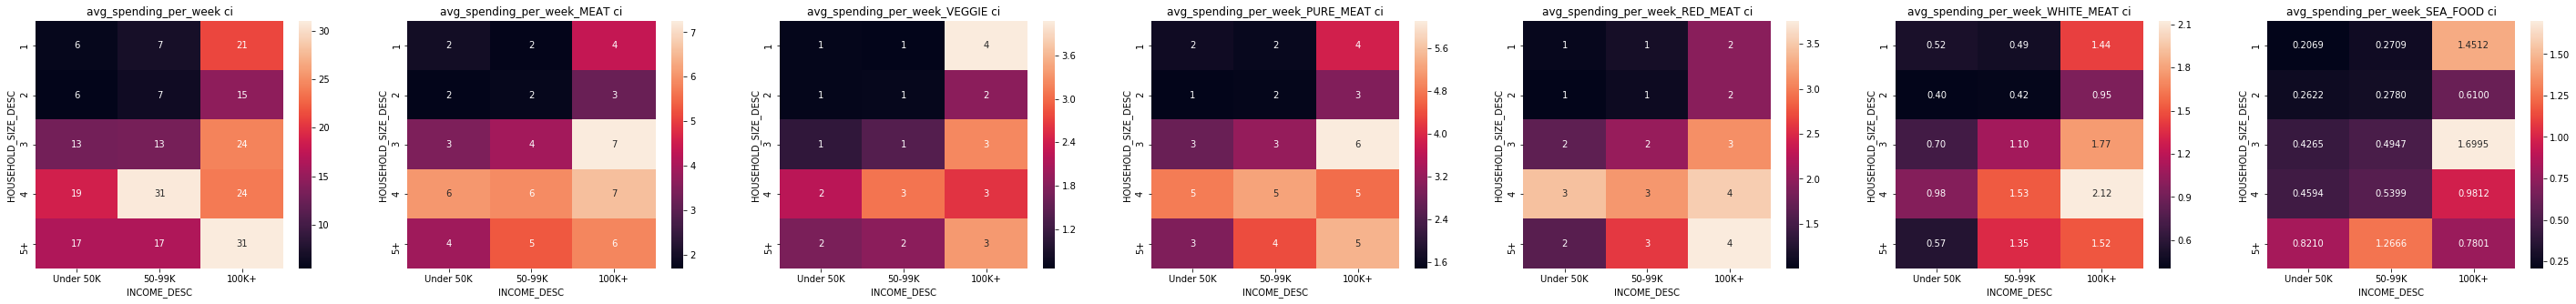

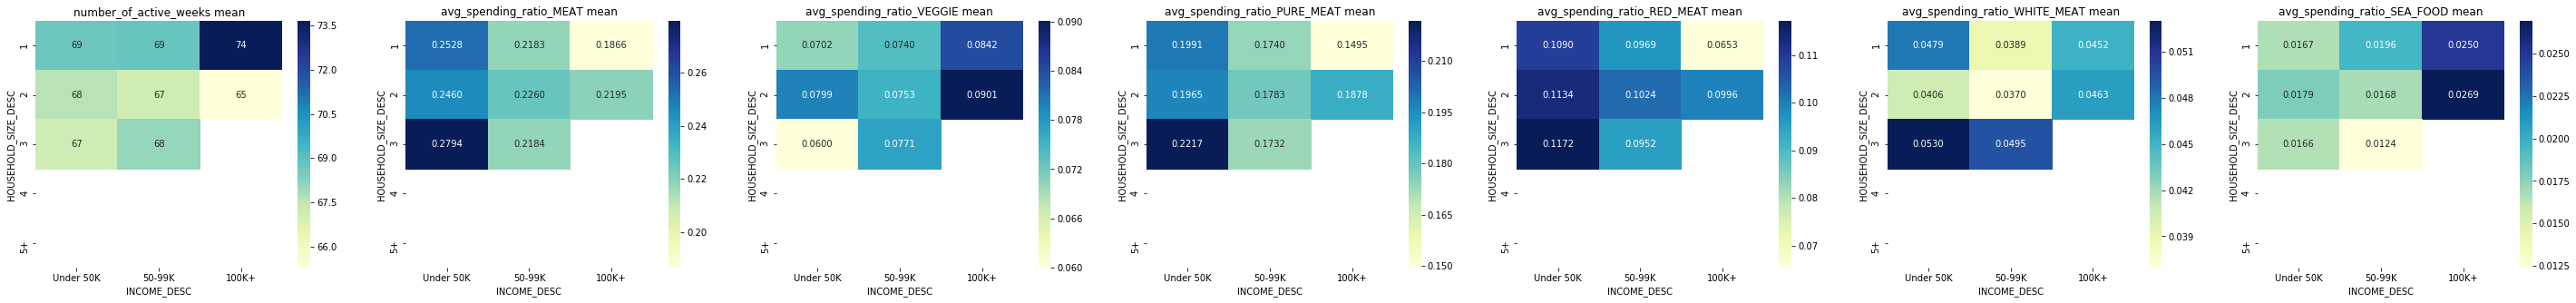

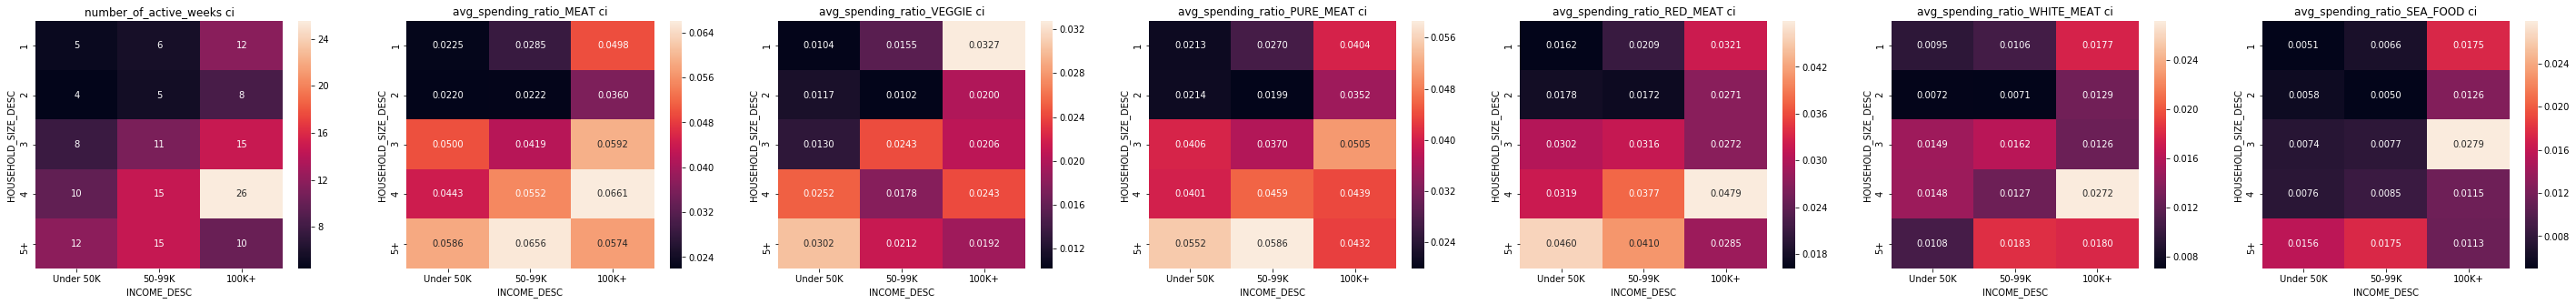

In [52]:
plot_heatmaps(('HOUSEHOLD_SIZE_DESC', 'INCOME_DESC'), 25)

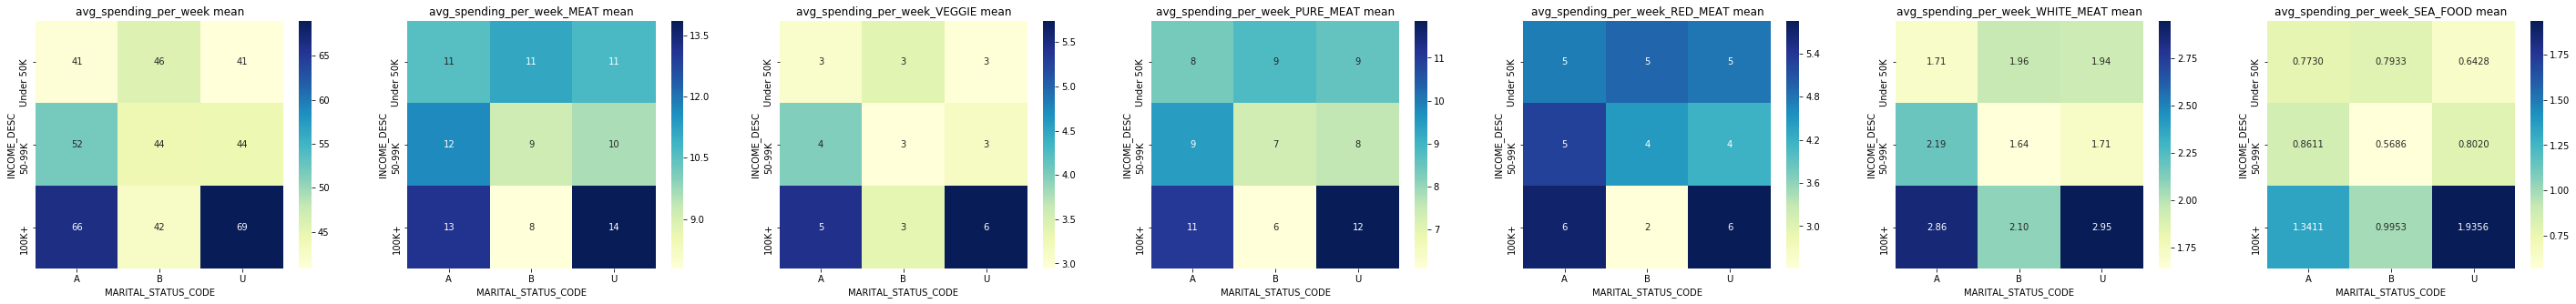

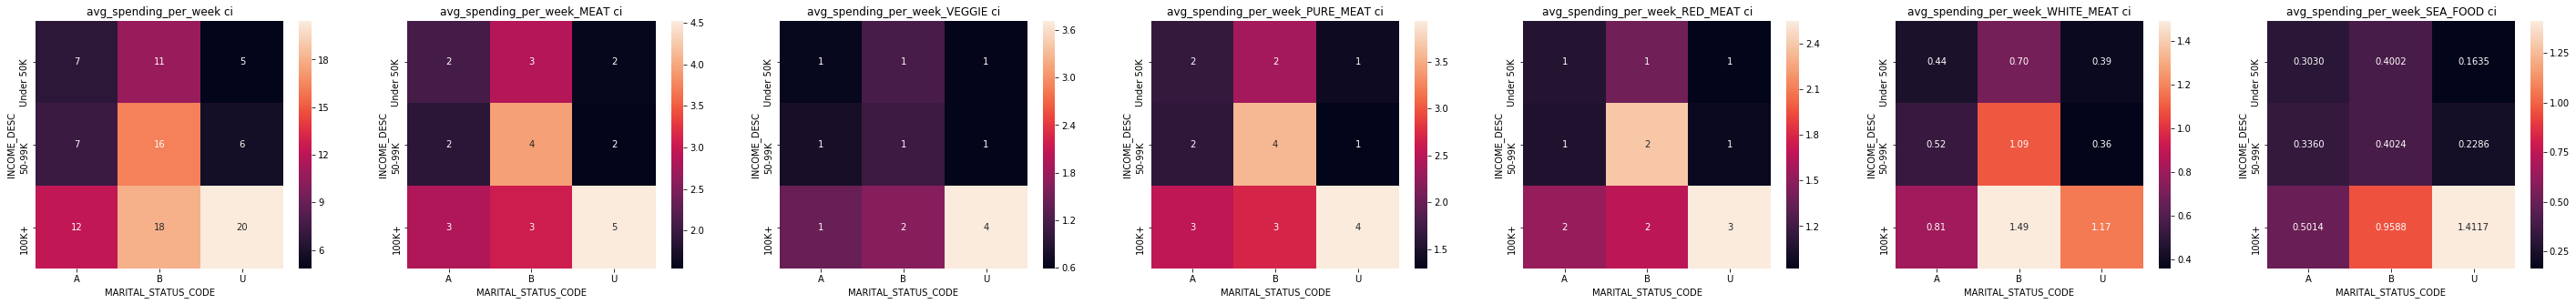

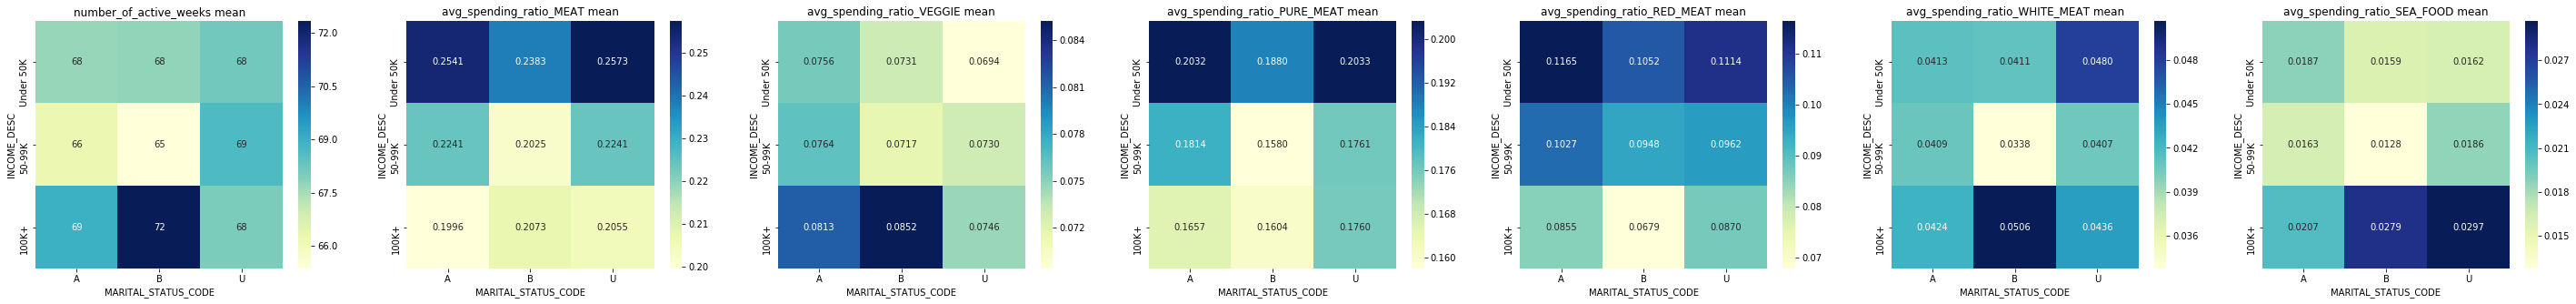

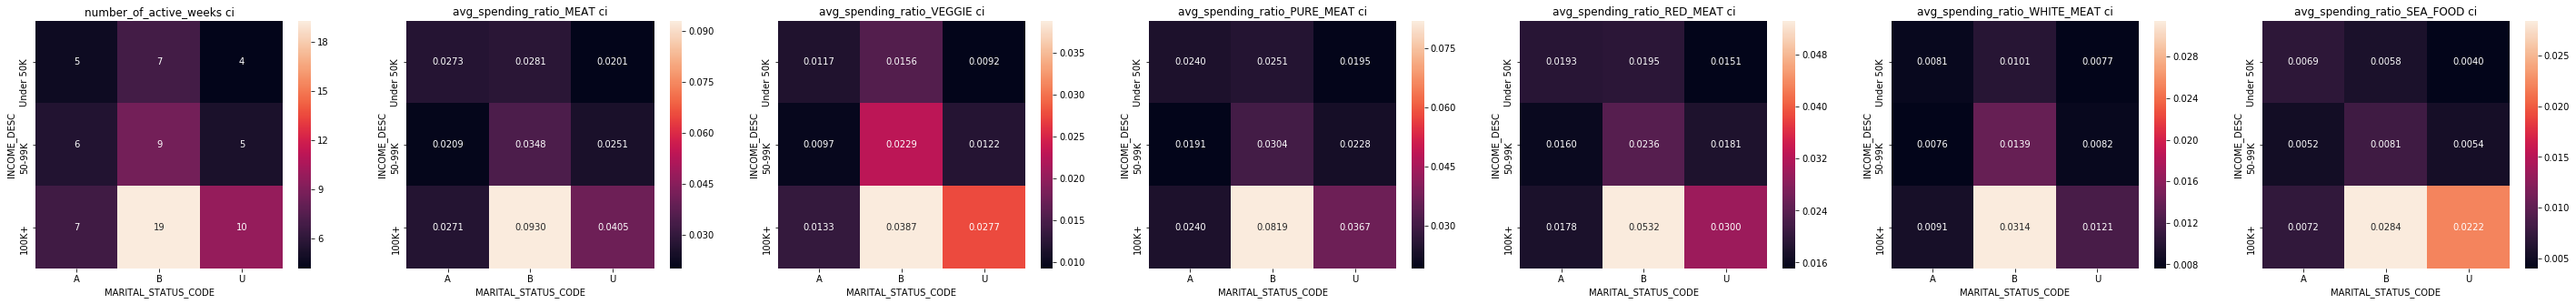

In [53]:
plot_heatmaps(('INCOME_DESC', 'MARITAL_STATUS_CODE'), 0)

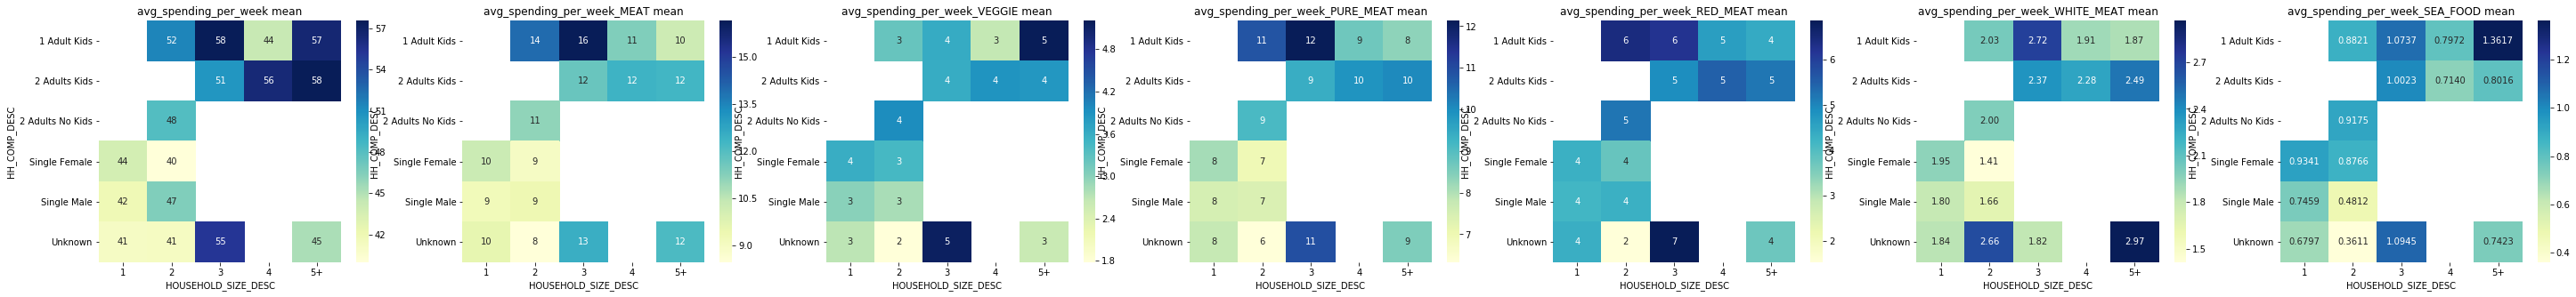

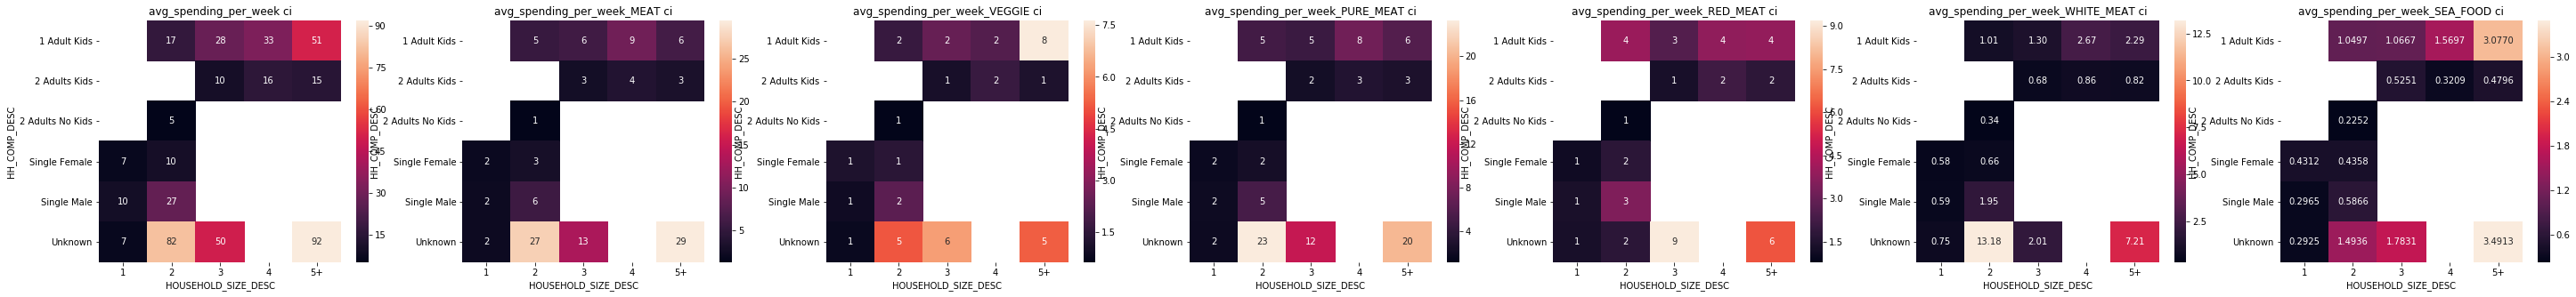

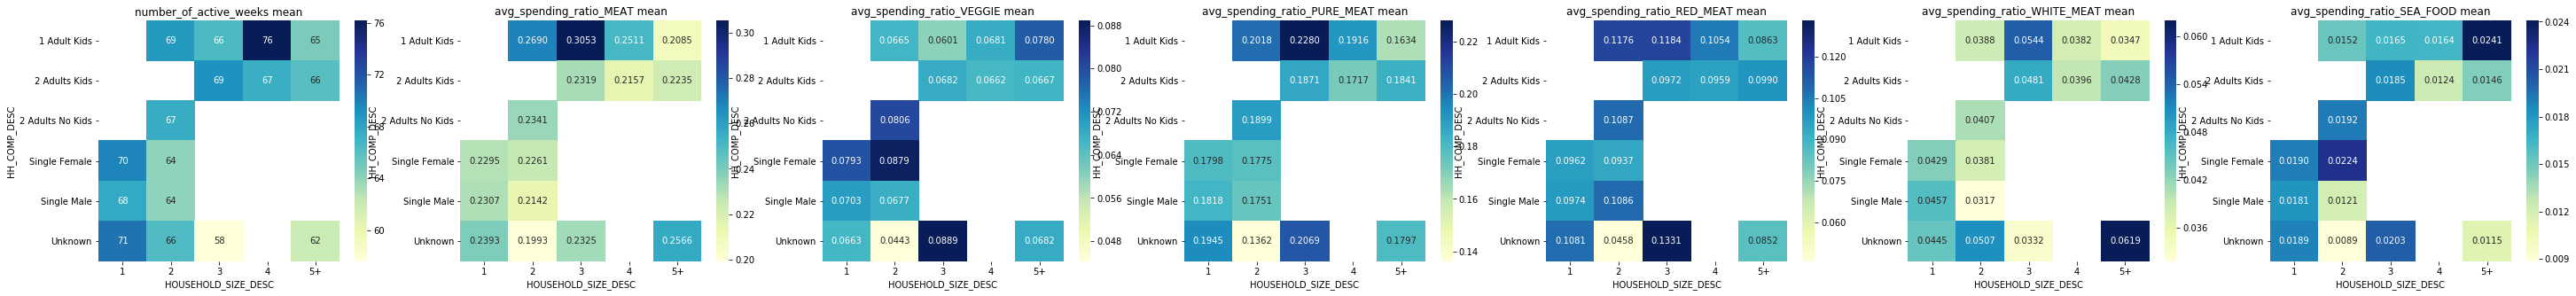

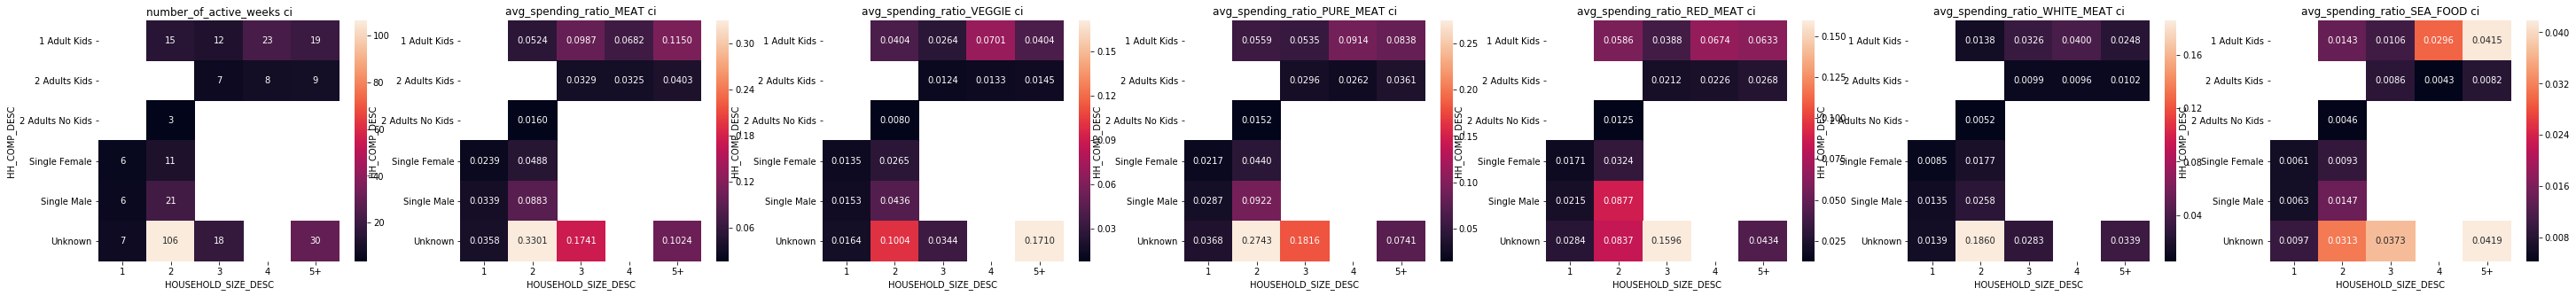

In [54]:
plot_heatmaps(('HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC'), 0)